# **CLIP Explainability**

In [1]:
# !git clone https://github.com/hila-chefer/Transformer-MM-Explainability

# import os
# os.chdir(f'./Transformer-MM-Explainability')

!pip install einops
!pip install ftfy
!pip install captum

# **CLIP**

In [2]:
import torch
import CLIP.clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization
import random

In [3]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

In [4]:
def interpret(image, texts, model, device, start_layer=start_layer, start_layer_text=start_layer_text):
    batch_size = texts.shape[0]
    images = image.repeat(batch_size, 1, 1, 1)
    logits_per_image, logits_per_text = model(images, texts)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.visual.transformer.resblocks.named_children()).values())

    if start_layer == -1: 
      # calculate index of last lareyer 
      start_layer = len(image_attn_blocks) - 1
    
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]

    
    text_attn_blocks = list(dict(model.transformer.resblocks.named_children()).values())

    if start_layer_text == -1: 
      # calculate index of last layer 
      start_layer_text = len(text_attn_blocks) - 1

    num_tokens = text_attn_blocks[0].attn_probs.shape[-1]
    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(text_attn_blocks):
        if i < start_layer_text:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text
   
    return text_relevance, image_relevance

In [5]:
def show_image_relevance(image_relevance, image, orig_image):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())
    vis = show_cam_on_image(image, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');

In [6]:
from CLIP.clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

def show_heatmap_on_text(text, text_encoding, R_text):
  CLS_idx = text_encoding.argmax(dim=-1)
  R_text = R_text[CLS_idx, 1:CLS_idx]
  text_scores = R_text / R_text.sum()
  text_scores = text_scores.flatten()
  print(text_scores)
  text_tokens=_tokenizer.encode(text)
  text_tokens_decoded=[_tokenizer.decode([a]) for a in text_tokens]
  vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,text_tokens_decoded,1)]
  visualization.visualize_text(vis_data_records)

In [7]:
clip.clip._MODELS = {
    "ViT-B/32": "https://openaipublic.azureedge.net/clip/models/40d365715913c9da98579312b702a82c18be219cc2a73407c4526f58eba950af/ViT-B-32.pt",
    "ViT-B/16": "https://openaipublic.azureedge.net/clip/models/5806e77cd80f8b59890b7e101eabd078d9fb84e6937f9e85e4ecb61988df416f/ViT-B-16.pt",
    "ViT-L/14": "https://openaipublic.azureedge.net/clip/models/b8cca3fd41ae0c99ba7e8951adf17d267cdb84cd88be6f7c2e0eca1737a03836/ViT-L-14.pt",
}

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)

/home/iai/anaconda3/envs/jwnew/lib/python3.8/site-packages/torchvision/transforms/transforms.py:257: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [9]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic)
    CenterCrop(size=(224, 224))
    <function _transform.<locals>.<lambda> at 0x7fcdad887160>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [10]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [11]:
def emphasize_attention(image_relevance, image):
    # Create heatmap from attention mask
    def create_heatmap(mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        return heatmap

    # Apply attention-based augmentation
    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())


    max_relevance = np.max(image_relevance)
    max_indices = np.argwhere(image_relevance == max_relevance)
    max_score = [(idx[1], idx[0]) for idx in max_indices]

    unique_values, value_counts = np.unique(image_relevance, return_counts=True)
    frequency_dict = dict(zip(unique_values, value_counts)) # Attention 값 빈도수

    print(frequency_dict)

    print("Pixel location of max score : ", max_score)

    # Emphasize attention regions in the image
    image = image[0].permute(1, 2, 0).data.cpu().numpy()
    image = (image - image.min()) / (image.max() - image.min())

    # Apply attention mask to image
    heatmap = create_heatmap(image_relevance)
    
    emphasized_image = (heatmap * image) + ((1 - heatmap) * 255)
    emphasized_image = np.uint8(emphasized_image)

    return emphasized_image, max_score



CLIP similarity score: 37.0625
tensor([0.0019, 0.0991, 0.0150, 0.0112, 0.3445, 0.5283], device='cuda:0',
       dtype=torch.float16)


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,a bottle of a glo ssier


{0.0: 16, 4.387e-05: 1, 4.756e-05: 16, 9.3e-05: 1, 9.567e-05: 16, 0.000131: 1, 0.0001421: 1, 0.0001432: 16, 0.0001549: 16, 0.0001616: 16, 0.0001686: 32, 0.0001755: 16, 0.0001823: 16, 0.0001833: 1, 0.000185: 1, 0.0001892: 16, 0.0001907: 16, 0.0001913: 1, 0.0001929: 1, 0.0001961: 16, 0.0001976: 1, 0.0002009: 1, 0.0002029: 32, 0.0002087: 1, 0.0002098: 16, 0.0002166: 17, 0.0002183: 1, 0.0002235: 16, 0.0002246: 1, 0.0002304: 16, 0.0002309: 1, 0.0002325: 1, 0.0002352: 1, 0.0002372: 32, 0.0002389: 16, 0.0002404: 2, 0.0002441: 17, 0.000249: 1, 0.000251: 16, 0.0002546: 2, 0.0002568: 1, 0.000258: 16, 0.0002642: 1, 0.0002646: 18, 0.0002716: 32, 0.0002728: 1, 0.0002732: 1, 0.000275: 1, 0.0002785: 16, 0.0002806: 1, 0.0002854: 17, 0.0002863: 17, 0.0002875: 1, 0.0002885: 1, 0.0002897: 1, 0.0002923: 16, 0.0002954: 1, 0.0002964: 1, 0.0002975: 1, 0.0002992: 16, 0.0003037: 1, 0.0003045: 1, 0.0003054: 1, 0.000306: 33, 0.0003123: 2, 0.0003128: 16, 0.000316: 1, 0.0003166: 1, 0.0003176: 1, 0.0003197: 16, 0.0

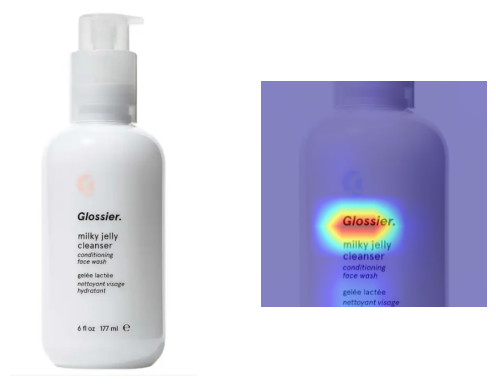

In [129]:
img_path = "./glossier2.PNG"
img = preprocess(Image.open(img_path)).unsqueeze(0).to(device)
texts = ["A bottle of a glossier"]
text = clip.tokenize(texts).to(device)

logits_per_image, logits_per_text = model(img, text)
print(color.BOLD + color.PURPLE + color.UNDERLINE + f'CLIP similarity score: {logits_per_image.item()}' + color.END)

R_text, R_image = interpret(model=model, image=img, texts=text, device=device)
batch_size = text.shape[0]
for i in range(batch_size):
    # Text heatmap
    show_heatmap_on_text(texts[i], text[i], R_text[i])
    
    # Image heatmap
    show_image_relevance(R_image[i], img, orig_image=Image.open(img_path))
    
    # Emphasize attention regions in the image
    _, max_score = emphasize_attention(R_image[i], img)
    
    # # Save the augmented image
    # augmented_img_path = f"augmented_image_{i}.jpg"
    # Image.fromarray(emphasized_image).save(augmented_img_path)


In [207]:
# Augmentation1 : crop 증강

def crop_object(image, max_score):
    # Randomly select a pixel from max_score
    selected_pixel = random.choice(max_score)
    

    # Set the region size for cropping the object
    min_region_size = int(0.30 * image.shape[0])  # 30% of image height
    max_region_size = int(0.60 * image.shape[0])  # 60% of image height
    

    # Randomly generate the region size within the specified range
    region_size = random.randint(min_region_size, max_region_size)

    # Extract the coordinates of the selected pixel
    x, y = selected_pixel

    # Define the coordinates for the region to be cropped
    x_start = max(0, x - region_size // 2)
    x_end = min(image.shape[1], x + region_size // 2)
    y_start = max(0, y - region_size // 2)
    y_end = min(image.shape[0], y + region_size // 2)

    # Crop the region from the image
    cropped_image = image[y_start:y_end, x_start:x_end].copy()

    return cropped_image


# Inference

image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 이미지 크기 변경
target_size = (224, 224)
image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)


cropped_image = crop_object(image, max_score)

cropped_img_path = "./cropped_image.jpg"
Image.fromarray(cropped_image).save(cropped_img_path)

In [236]:
# Augmentation2 : highlight 증강

def highlight_object(image, max_score):
    # Randomly select a pixel from max_score
    selected_pixel = random.choice(max_score)

    # Set the region size for emphasizing the object
    min_region_size = int(0.30 * image.shape[0])  # 30% of image height
    max_region_size = int(0.60 * image.shape[0])  # 60% of image height
    

    # Randomly generate the region size within the specified range
    region_size = random.randint(min_region_size, max_region_size)

    # Extract the coordinates of the selected pixel
    x, y = selected_pixel

    # Define the coordinates for the region to be emphasized
    x_start = max(0, x - region_size // 2)
    x_end = min(image.shape[1], x + region_size // 2)
    y_start = max(0, y - region_size // 2)
    y_end = min(image.shape[0], y + region_size // 2)

    # Apply blur to the non-emphasized region
    emphasized_image = image.copy()
    if y_start > 0:
        emphasized_image[:y_start, :] = cv2.blur(emphasized_image[:y_start, :], (15, 15))
    if y_end < image.shape[0]:
        emphasized_image[y_end:, :] = cv2.blur(emphasized_image[y_end:, :], (15, 15))
    if x_start > 0:
        emphasized_image[:, :x_start] = cv2.blur(emphasized_image[:, :x_start], (15, 15))
    if x_end < image.shape[1]:
        emphasized_image[:, x_end:] = cv2.blur(emphasized_image[:, x_end:], (15, 15))

    # Apply color/brightness/sharpness adjustment to the emphasized region
    alpha = random.uniform(0.5, 2.0)  # Random scale factor for color adjustment
    beta = random.randint(-50, 50)  # Random offset for brightness adjustment
    gamma = random.uniform(0.5, 1.5)  # Random gamma factor for sharpness adjustment

    # Apply color/brightness/sharpness adjustment to the emphasized region
    emphasized_image[y_start:y_end, x_start:x_end] = cv2.convertScaleAbs(
        emphasized_image[y_start:y_end, x_start:x_end], alpha=alpha, beta=beta)
    emphasized_image[y_start:y_end, x_start:x_end] = cv2.addWeighted(
        emphasized_image[y_start:y_end, x_start:x_end], gamma, emphasized_image[y_start:y_end, x_start:x_end], 0, 0)

    return emphasized_image



# Inference
image = cv2.imread(img_path)
# Convert BGR to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 이미지 크기 변경
target_size = (224, 224)
image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

highlighted_image = highlight_object(image, max_score)

print(highlighted_image.shape)


highlighted_img_path = "./highlight_image.jpg"
Image.fromarray(highlighted_image).save(highlighted_img_path)


(224, 224, 3)
